# Import libraries

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import logging 

# Helper functions for data preprocessing and model training

In [6]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

def preprocess_data(full_df, target_col='Outperform', drop_cols=['PRICE VAR [%]', 'Class', 'Symbol']):
    """
    Preprocess the dataset by splitting into training, validation, and test sets,
    balancing classes with SMOTE, and standardizing features with StandardScaler.
    
    Parameters:
    - full_df: pd.DataFrame, the full merged dataset
    - target_col: str, the target variable name ('Outperform')
    - drop_cols: list, columns to drop due to data leakage or irrelevance
    
    Returns:
    - X_train, X_val, X_test: feature matrices for train, validation, and test sets
    - y_train, y_val, y_test: target variables for train, validation, and test sets
    - scaler: the StandardScaler object fitted on the training data
    """
    
    # Split the data by year
    train_data = full_df[full_df['Year'].isin([2014, 2015, 2016])]
    val_data_first_half = full_df[(full_df['Year'] == 2017) & (full_df.index < len(full_df) / 2)]
    val_data_second_half = full_df[(full_df['Year'] == 2017) & (full_df.index >= len(full_df) / 2)]
    test_data = full_df[full_df['Year'] == 2018]
    
    # Combine training and validation data for first half of 2017
    train_data = pd.concat([train_data, val_data_first_half], axis=0)
    
    logging.info(f"Training data size: {train_data.shape}")
    logging.info(f"Validation data size (second half 2017): {val_data_second_half.shape}")
    logging.info(f"Test data size (2018): {test_data.shape}")
    
    # Drop the columns that may cause data leakage
    X_train = train_data.drop(columns=drop_cols + [target_col])
    y_train = train_data[target_col]
    
    X_val = val_data_second_half.drop(columns=drop_cols + [target_col])
    y_val = val_data_second_half[target_col]
    
    X_test = test_data.drop(columns=drop_cols + [target_col])
    y_test = test_data[target_col]
    
    # Handle class imbalance using SMOTE on the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    logging.info(f"After SMOTE, training data size: {X_train_smote.shape}")
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_smote)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Train the model and evaluate it on validation data, including confusion matrix and classification report.
    
    Parameters:
    - model: the machine learning model to train
    - X_train: training features
    - y_train: training labels
    - X_val: validation features
    - y_val: validation labels
    
    Returns:
    - classification report and confusion matrix
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on validation data
    y_pred = model.predict(X_val)
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()
    
    # Classification Report
    report = classification_report(y_val, y_pred)
    print(f"Classification Report for {model.__class__.__name__}:\n")
    print(report)
    
    return y_pred


# Load dataset

In [3]:
df = pd.read_csv('data/for_modeling_datasets/full_Financial_Data_for_modeling.csv')
df.head()

,Symbol,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,...,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
0,PG,1.664037e+10,-0.071300,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.794415e+09,2.049441e+09,3.144514e+08,...,0,0,1,0,0,0,0,0,0,0
1,VIPS,3.734148e+09,1.148175,2.805625e+09,9.285226e+08,100397250.0,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,...,0,0,1,0,0,0,0,0,0,0
2,KR,1.664037e+10,0.018200,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.794415e+09,2.049441e+09,3.144514e+08,...,0,0,1,0,0,0,0,0,0,0
3,RAD,1.664037e+10,0.005300,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.794415e+09,7.372520e+08,3.144514e+08,...,0,0,1,0,0,0,0,0,0,0
4,GIS,1.664037e+10,0.007600,8.829338e+09,6.055261e+09,0.0,2.283773e+09,3.412400e+09,2.049441e+09,3.024000e+08,...,0,0,1,0,0,0,0,0,0,0


# Train the model

2024-10-01 11:17:29,983 - Training data size: (12725, 201)
2024-10-01 11:17:29,984 - Validation data size (second half 2017): (4960, 201)
2024-10-01 11:17:29,984 - Test data size (2018): (4392, 201)
2024-10-01 11:17:30,141 - After SMOTE, training data size: (14322, 197)


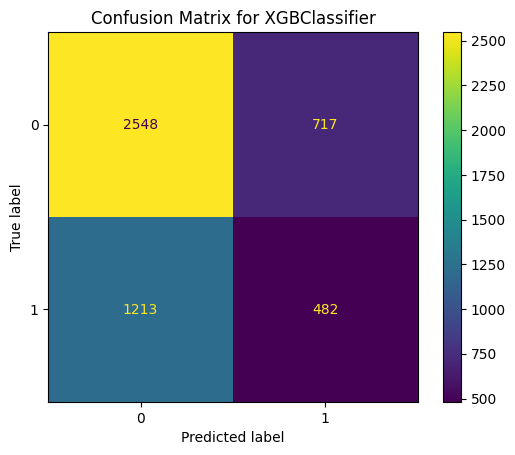

Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       0.68      0.78      0.73      3265
           1       0.40      0.28      0.33      1695

    accuracy                           0.61      4960
   macro avg       0.54      0.53      0.53      4960
weighted avg       0.58      0.61      0.59      4960



In [8]:
Hyperparameter Tuning with GridSearchCV# Run
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df)

# Initialize XGBoost Classifier
xgb_model = XGBClassifier(random_state=42)

# Call the function to train and evaluate the model
y_pred_xgb = train_and_evaluate_model(xgb_model, X_train, y_train, X_val, y_val)

# Hyperparameter Tuning with GridSearchCV

In [10]:
# Initialize XGBoost Classifier
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of boosting rounds
    'max_depth': [3, 4, 5],                # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2],     # Step size shrinkage
    'subsample': [0.8, 1.0],               # Subsample ratio of the training instance
    'colsample_bytree': [0.8, 1.0],        # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.3],                # Minimum loss reduction required to make a further partition
    'reg_alpha': [0, 0.1, 1],              # L1 regularization term on weights
    'reg_lambda': [1, 1.5],                # L2 regularization term on weights
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    scoring='f1',  
    cv=5,          # 5-fold cross-validation
    verbose=1,
    n_jobs=-1      # Use all available cores
)

# Save the search progress periodically
checkpoint_filename = 'xgb_grid_search_checkpoint.pkl'

try:
    grid_search.fit(X_train, y_train)
except KeyboardInterrupt:
    # Save the current state of the GridSearchCV object
    joblib.dump(grid_search, checkpoint_filename)
    print(f'Search interrupted and saved to {checkpoint_filename}')

# If interrupted, you can load the previous checkpoint and resume
# grid_search = joblib.load(checkpoint_filename)

# Best parameters
if hasattr(grid_search, 'best_params_'):
    print("Best parameters found:", grid_search.best_params_)
    
    # Use the best estimator to make predictions
    best_xgb = grid_search.best_estimator_
    y_pred_best = best_xgb.predict(X_test)

    # Evaluate the optimized model
    print(classification_report(y_test, y_pred_best))
else:
    print('Search did not complete or no best parameters were found.')

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.68      0.67      0.68      2877
           1       0.39      0.40      0.40      1515

    accuracy                           0.58      4392
   macro avg       0.54      0.54      0.54      4392
weighted avg       0.58      0.58      0.58      4392

